<a href="https://colab.research.google.com/github/Eng-DanielaNunes/collective-intelligence-lab/blob/main/notebooks/daninunes_sisdac_2025_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Arquivo CSV não fornecido ou não encontrado. Gerando dataset mock para testes.

=== Estatísticas descritivas (por critério) ===
                                   mean   median      std   variance  \
Horas_Trabalhadas_Semanais       57.375   56.000    7.289     53.125   
Percentual_Formalizacao           0.669    0.760    0.273      0.075   
Remuneracao_Minima                1.856    1.745    0.408      0.166   
Condicoes_Seguranca_Saude         0.651    0.645    0.129      0.017   
Rotatividade                      0.270    0.255    0.174      0.030   
Treinamento_Qualificacao          0.380    0.350    0.310      0.096   
Igualdade_Genero                  0.614    0.605    0.282      0.079   
Consumo_Agua_Unitario           201.312  174.950  119.677  14322.578   
Emissao_Energetica_por_unidade    4.710    3.870    2.569      6.600   
Transparencia_Cadeia              0.625    0.750    0.336      0.113   

                                coef_var_%  
Horas_Trabalhadas_Semanais        

/tmp/ipython-input-154490667.py:197: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Fornecedor', y='Topsis_Score', data=resultado, palette='Set2', dodge=False)


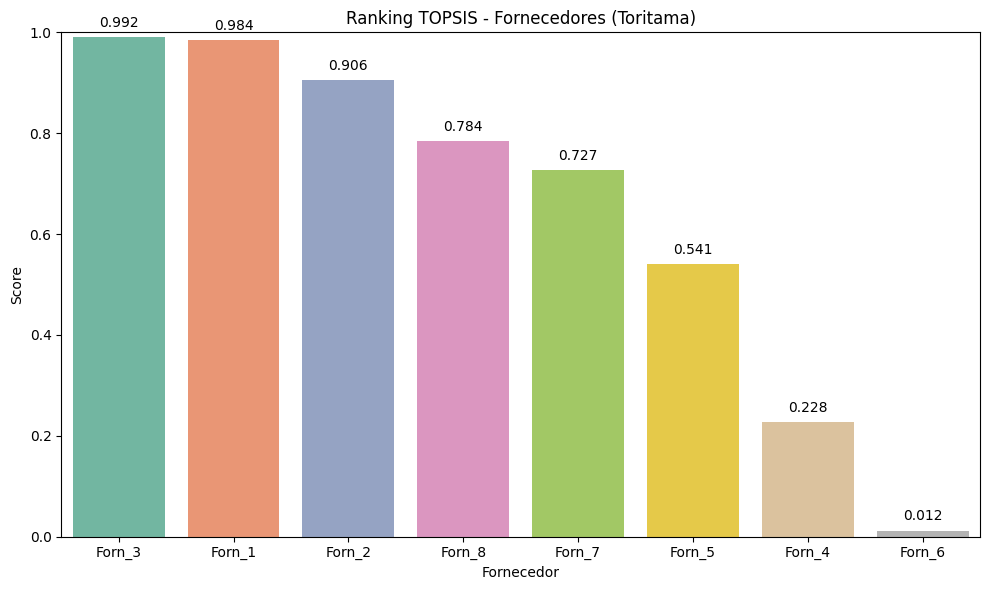

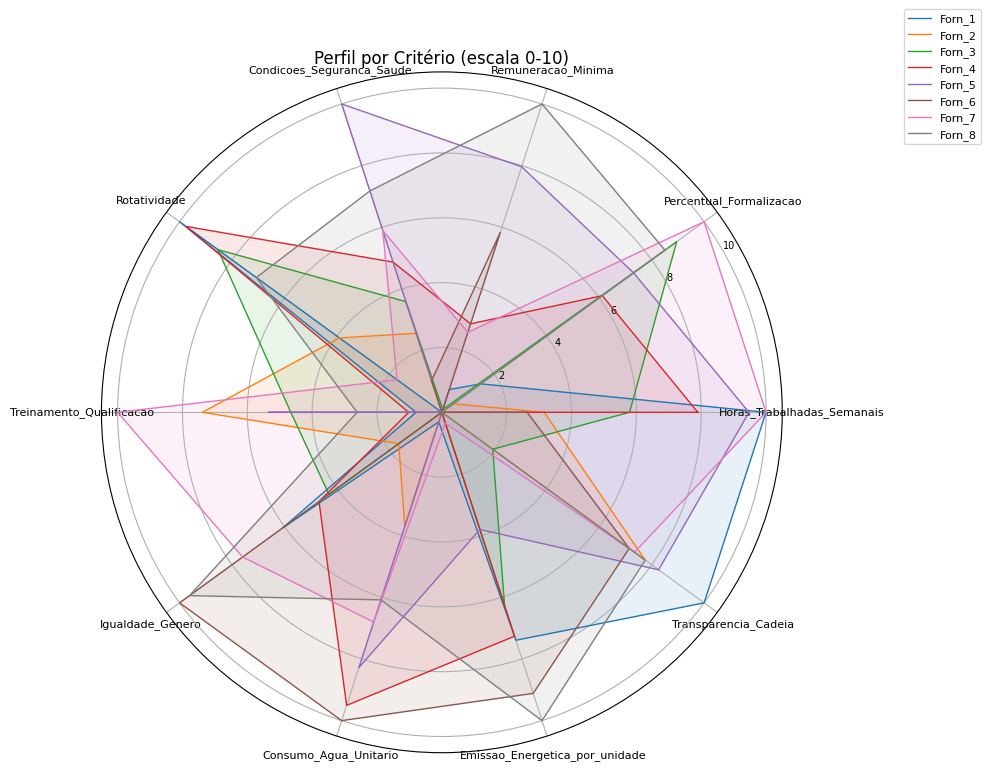

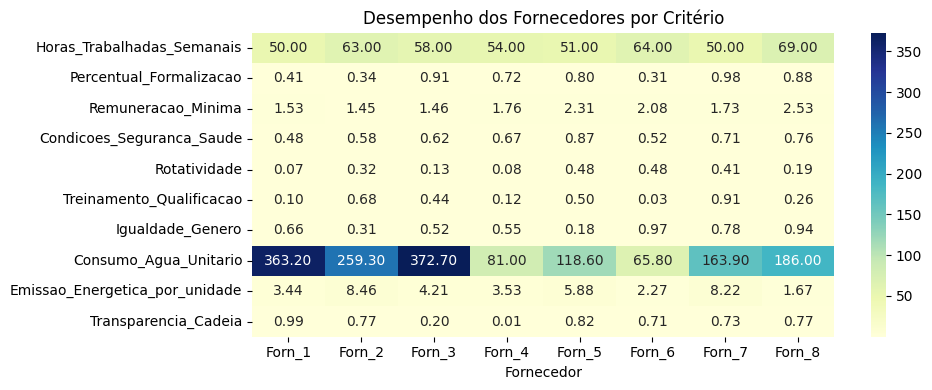


Arquivo "Relatorio_TOPSIS_Fornecedor_Toritama.xlsx" salvo no diretório atual.

Top 3 Fornecedores:
  Fornecedor  Topsis_Score
0     Forn_3      0.991518
1     Forn_1      0.984121
2     Forn_2      0.906175


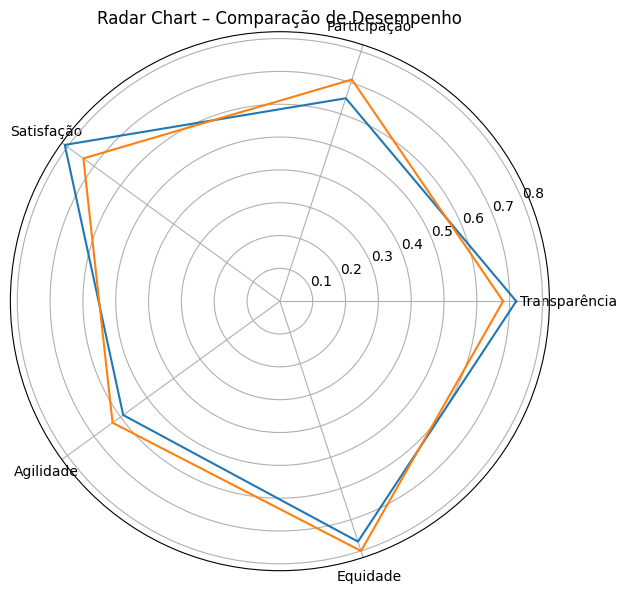

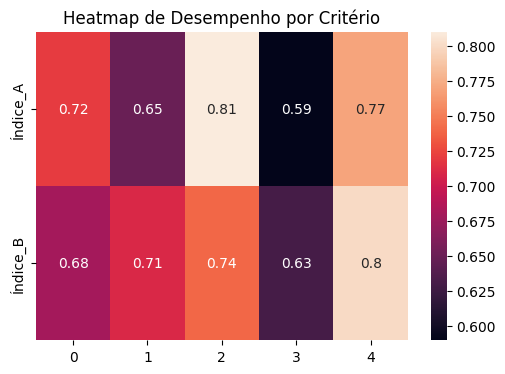

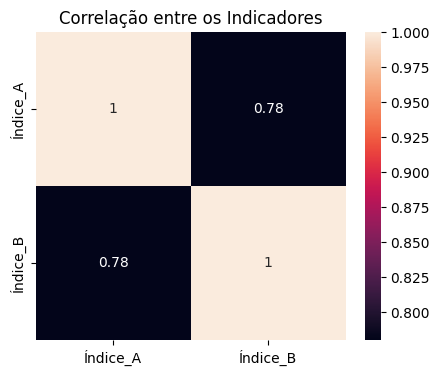

In [1]:
"""
# Projeto: SISDAC - Sistema de Apoio à Decisão em Ambientes Cívicos (Toritama-PE)
# Autora: Daniela Nunes dos Santos Ferreira
# Ano de Desenvolvimento: 2025
# Versão: 1.0
# Descrição: Sistema de Apoio à Decisão Multicritério (SISDAC)
# Objetivo: adaptar o SISDAC – Sistema de Apoio à Decisão em Ambientes Cívicos
para avaliar e ranquear fornecedores têxteis na cadeia do jeans em Toritama-PE, incluindo indicadores sociais mapeados para
metas da Agenda 2030 (ODS) e gerando outputs (ranking TOPSIS, radar, heatmap e exportação Excel).


# ADAPTAÇÃO PARA O CASO REAL DE TORITAMA (IPEA)
#Toritama, situada no Agreste Pernambucano, constitui um dos principais polos de confecção do país, com forte dependência econômica das cadeias têxteis. Dados do IBGE, RAIS, Censo Demográfico e estatísticas municipais evidenciam um ambiente produtivo marcado por elevada informalidade, jornadas extensas, ausência de mecanismos estruturados de seleção de fornecedores e fragilidades em práticas de sustentabilidade social e laboral.

#A presente pesquisa propõe a modelagem de um Sistema Multicritério de Apoio à Decisão para seleção sustentável de fornecedores, integrando indicadores sociais, econômicos e trabalhistas alinhados às metas dos Objetivos de Desenvolvimento Sustentável (ODS) da Agenda 2030. O modelo utiliza bases oficiais (IBGE, Censo, RAIS e dados municipais) e métodos de análise multicritério para subsidiar políticas públicas e práticas empresariais voltadas à geração de trabalho digno, fortalecimento das cadeias produtivas e transparência social.

-
Instruções de Uso:

Como usar:
- Execute o arquivo em um ambiente Python (recomendo Jupyter/Colab).
- Instale requisitos se necessário: pandas, numpy, matplotlib, seaborn, openpyxl.
- Forneça um arquivo CSV com as colunas: 'Fornecedor' + os critérios (veja lista
  padrão abaixo) OU deixe o script gerar dados mock para testes.

Saída:
- Relatório Excel 'Relatorio_TOPSIS_Fornecedor_Toritama.xlsx'
- Gráficos: ranking, radar, heatmap
- Console com mapeamento Critério -> ODS e interpretação básica

"""

# Instalação de bibliotecas (descomente se necessário)
# !pip install pandas numpy matplotlib seaborn openpyxl --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import os

# ----------------------- Configurações iniciais -----------------------------
# Critérios sugeridos e seu mapeamento para ODS (Agenda 2030)
CRITERIA_ODS_MAP = {
    'Horas_Trabalhadas_Semanais': 'ODS 8.5 (Trabalho decente)',
    'Percentual_Formalizacao': 'ODS 8.7 / ODS 8.8',
    'Remuneracao_Minima': 'ODS 1 / ODS 8',
    'Condicoes_Seguranca_Saude': 'ODS 3 / ODS 8',
    'Rotatividade': 'ODS 8 (estabilidade de emprego)',
    'Treinamento_Qualificacao': 'ODS 4 (Educação de qualidade)',
    'Igualdade_Genero': 'ODS 5 (Igualdade de gênero)',
    'Consumo_Agua_Unitario': 'ODS 6 / ODS 12 (recursos naturais)',
    'Emissao_Energetica_por_unidade': 'ODS 13 / ODS 12',
    'Transparencia_Cadeia': 'ODS 16 / ODS 12',
}

# Para cada critério, definir se é benefício (True) ou custo (False)
BENEFIT_CRITERIA = {
    'Horas_Trabalhadas_Semanais': False,  # menos horas = melhor
    'Percentual_Formalizacao': True,
    'Remuneracao_Minima': True,
    'Condicoes_Seguranca_Saude': True,
    'Rotatividade': False,
    'Treinamento_Qualificacao': True,
    'Igualdade_Genero': True,
    'Consumo_Agua_Unitario': False,
    'Emissao_Energetica_por_unidade': False,
    'Transparencia_Cadeia': True,
}

DEFAULT_CRITERIA = list(CRITERIA_ODS_MAP.keys())

# ----------------------- Funções utilitárias --------------------------------

def gerar_mock_data(n_fornecedores=8, seed=42):
    np.random.seed(seed)
    fornecedores = [f'Forn_{i+1}' for i in range(n_fornecedores)]
    data = {}
    # Gera valores plausíveis por critério
    data['Fornecedor'] = fornecedores
    data['Horas_Trabalhadas_Semanais'] = np.random.randint(44, 70, size=n_fornecedores)  # custo
    data['Percentual_Formalizacao'] = np.round(np.random.uniform(0.3, 1.0, size=n_fornecedores), 2)  # benefício (0-1)
    data['Remuneracao_Minima'] = np.round(np.random.uniform(1.0, 3.5, size=n_fornecedores), 2)  # salários mínimos
    data['Condicoes_Seguranca_Saude'] = np.round(np.random.uniform(0.4, 1.0, size=n_fornecedores), 2)
    data['Rotatividade'] = np.round(np.random.uniform(0.05, 0.5, size=n_fornecedores), 2)
    data['Treinamento_Qualificacao'] = np.round(np.random.uniform(0.0, 1.0, size=n_fornecedores), 2)
    data['Igualdade_Genero'] = np.round(np.random.uniform(0.0, 1.0, size=n_fornecedores), 2)
    data['Consumo_Agua_Unitario'] = np.round(np.random.uniform(50, 400, size=n_fornecedores), 1)  # litros por peça
    data['Emissao_Energetica_por_unidade'] = np.round(np.random.uniform(1.0, 10.0, size=n_fornecedores), 2)
    data['Transparencia_Cadeia'] = np.round(np.random.uniform(0.0, 1.0, size=n_fornecedores), 2)
    return pd.DataFrame(data)


def carregar_ou_gerar_dados(path_csv=None):
    if path_csv and os.path.exists(path_csv):
        df = pd.read_csv(path_csv)
        # Verificar colunas necessárias
        expected = ['Fornecedor'] + DEFAULT_CRITERIA
        missing = set(expected) - set(df.columns)
        if missing:
            raise ValueError(f"Arquivo CSV não contém colunas esperadas. Faltam: {missing}")
        return df[expected]
    else:
        print("Arquivo CSV não fornecido ou não encontrado. Gerando dataset mock para testes.")
        return gerar_mock_data()


# ----------------------- Métodos de ponderação (CRITIC) ----------------------

def pesos_critic(df_criterios, benefit_criteria):
    # df_criterios: DataFrame (fornecedores x critérios)
    # Normalizar (z-score)
    Z = (df_criterios - df_criterios.mean()) / df_criterios.std(ddof=0)
    R = Z.corr().abs()
    std = df_criterios.std(ddof=0)
    # Contraste: 1 - sum das correlações
    contrast = (1 - R).sum(axis=1)
    weights = (std * contrast) / ((std * contrast).sum())
    return weights

# ----------------------- TOPSIS (com pesos fornecidos) ----------------------

def topsis(df_criterios, benefit_criteria, weights=None):
    # df_criterios: fornecedores x critérios (numérico)
    M = df_criterios.copy().astype(float)
    # Normalização vetorial (coluna a coluna)
    norm = M / np.sqrt((M**2).sum())

    # Ajuste para critérios de custo: transformar em benefício (inverter)
    for col, is_benefit in benefit_criteria.items():
        if not is_benefit:
            norm[col] = (1 / M[col]) / np.sqrt(((1 / M[col])**2).sum())

    if weights is None:
        weights = np.ones(len(M.columns)) / len(M.columns)
    else:
        # garantir ordem correta
        weights = weights.reindex(M.columns).fillna(0).values

    weighted = norm * weights

    # Solução ideal e anti-ideal
    ideal = np.array([weighted[col].max() if benefit_criteria[col] else weighted[col].min() for col in M.columns])
    anti_ideal = np.array([weighted[col].min() if benefit_criteria[col] else weighted[col].max() for col in M.columns])

    dist_ideal = np.sqrt(((weighted - ideal)**2).sum(axis=1))
    dist_anti = np.sqrt(((weighted - anti_ideal)**2).sum(axis=1))
    score = dist_anti / (dist_ideal + dist_anti)
    return score, weighted, dist_ideal, dist_anti


# ----------------------- Função principal ----------------------------------

def executar_pipeline(path_csv=None, salvar_excel=True):
    df = carregar_ou_gerar_dados(path_csv)

    fornecedores = df['Fornecedor']
    df_crit = df[DEFAULT_CRITERIA].copy()

    # Estatísticas descritivas
    desc = df_crit.describe().T
    desc['median'] = df_crit.median()
    desc['variance'] = df_crit.var()
    desc['coef_var_%'] = (df_crit.std() / df_crit.mean()) * 100

    print('\n=== Estatísticas descritivas (por critério) ===')
    print(desc[['mean', 'median', 'std', 'variance', 'coef_var_%']].round(3))

    # Matriz de correlação
    corr = df_crit.corr()
    print('\n=== Matriz de Correlação entre critérios ===')
    print(corr.round(3))

    # Ponderação usando CRITIC
    pesos = pesos_critic(df_crit, BENEFIT_CRITERIA)
    pesos.index = df_crit.columns
    print('\nPesos (CRITIC):')
    print(pesos.round(4))

    # TOPSIS
    score, weighted_matrix, dist_ideal, dist_anti = topsis(df_crit, BENEFIT_CRITERIA, weights=pesos)

    resultado = pd.DataFrame({
        'Fornecedor': fornecedores,
        'Topsis_Score': score,
        'Distancia_Ideal': dist_ideal,
        'Distancia_Anti_Ideal': dist_anti
    })
    resultado = resultado.sort_values('Topsis_Score', ascending=False).reset_index(drop=True)

    print('\n=== Ranking TOPSIS (fornecedores) ===')
    print(resultado[['Fornecedor', 'Topsis_Score']].round(4))

    # Gráfico de ranking
    plt.figure(figsize=(10,6))
    sns.barplot(x='Fornecedor', y='Topsis_Score', data=resultado, palette='Set2', dodge=False)
    plt.ylim(0,1)
    plt.title('Ranking TOPSIS - Fornecedores (Toritama)')
    plt.ylabel('Score')
    plt.xlabel('Fornecedor')
    for idx, row in resultado.iterrows():
        plt.text(idx, row['Topsis_Score'] + 0.02, f"{row['Topsis_Score']:.3f}", ha='center')
    plt.tight_layout()
    plt.show()

    # Radar chart (normalizar 0-10)
    normed_rad = df_crit.copy()
    for col in normed_rad.columns:
        if BENEFIT_CRITERIA[col]:
            normed_rad[col] = (normed_rad[col] - normed_rad[col].min()) / (normed_rad[col].max() - normed_rad[col].min()) * 10
        else:
            normed_rad[col] = (normed_rad[col].max() - normed_rad[col]) / (normed_rad[col].max() - normed_rad[col].min()) * 10

    categories = list(normed_rad.columns)
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(9,8))
    ax = plt.subplot(111, polar=True)
    for i in range(len(normed_rad)):
        values = normed_rad.iloc[i].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=df['Fornecedor'].iloc[i])
        ax.fill(angles, values, alpha=0.1)

    plt.xticks(angles[:-1], categories, fontsize=8)
    ax.set_rlabel_position(30)
    plt.yticks([2,4,6,8,10], ['2','4','6','8','10'], fontsize=7)
    plt.title('Perfil por Critério (escala 0-10)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=8)
    plt.tight_layout()
    plt.show()

    # Heatmap
    plt.figure(figsize=(10, max(4, len(df)/2)))
    sns.heatmap(df_crit.set_index(fornecedores).T, annot=True, fmt='.2f', cmap='YlGnBu')
    plt.title('Desempenho dos Fornecedores por Critério')
    plt.tight_layout()
    plt.show()

    # Exportar para Excel
    if salvar_excel:
        with pd.ExcelWriter('Relatorio_TOPSIS_Fornecedor_Toritama.xlsx') as writer:
            df.to_excel(writer, sheet_name='01_Raw_Data', index=False)
            df_crit.to_excel(writer, sheet_name='02_Criteria', index=False)
            pd.DataFrame(pesos, columns=['Peso']).to_excel(writer, sheet_name='03_Pesos')
            resultado.to_excel(writer, sheet_name='04_Ranking', index=False)
            weighted_matrix.to_excel(writer, sheet_name='05_Weighted_Matrix')

        print('\nArquivo "Relatorio_TOPSIS_Fornecedor_Toritama.xlsx" salvo no diretório atual.')

    # Retornar objetos para uso posterior
    return {
        'raw': df,
        'criteria': df_crit,
        'pesos': pesos,
        'resultado': resultado,
        'weighted_matrix': weighted_matrix,
        'dist_ideal': dist_ideal,
        'dist_anti': dist_anti
    }


# ----------------------- Execução direta (se executado como script) ---------
if __name__ == '__main__':
    # Se tiver um CSV local, passe o caminho para executar_pipeline(path_csv='dados_fornecedores.csv')
    outputs = executar_pipeline()

    # Exemplo: acessar ranking
    ranking = outputs['resultado']
    print('\nTop 3 Fornecedores:')
    print(ranking.head(3)[['Fornecedor', 'Topsis_Score']])

# Fim do script

## 4. Código em Python (com Indicadores Sociais, Radar Chart, Heatmap e Correlações)python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns

# ---------------------
# CARREGAR DADOS
# ---------------------
# Exemplo de dataset (substituir pelo dataset real da pesquisa de Toritama)
dados = pd.DataFrame({
    'Critério': ['Transparência', 'Participação', 'Satisfação', 'Agilidade', 'Equidade'],
    'Índice_A': [0.72, 0.65, 0.81, 0.59, 0.77],
    'Índice_B': [0.68, 0.71, 0.74, 0.63, 0.80]
})

# ---------------------
# RADAR CHART
# ---------------------
labels = dados['Critério']
valores_A = dados['Índice_A']
valores_B = dados['Índice_B']
n = len(labels)

angles = [i / float(n) * 2 * pi for i in range(n)]
valores_A = list(valores_A) + [valores_A[0]]
valores_B = list(valores_B) + [valores_B[0]]
angles += [angles[0]]

plt.figure(figsize=(7,7))
plt.polar(angles, valores_A)
plt.polar(angles, valores_B)
plt.xticks(angles[:-1], labels)
plt.title('Radar Chart – Comparação de Desempenho')
plt.show()

# ---------------------
# HEATMAP DE DESEMPENHO
# ---------------------
plt.figure(figsize=(6,4))
sns.heatmap(dados[['Índice_A','Índice_B']].T, annot=True)
plt.title('Heatmap de Desempenho por Critério')
plt.show()

# ---------------------
# MATRIZ DE CORRELAÇÃO
# ---------------------
plt.figure(figsize=(5,4))
corr = dados[['Índice_A','Índice_B']].corr()
sns.heatmap(corr, annot=True)
plt.title('Correlação entre os Indicadores')
plt.show()